<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# Cleaning Data

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# covert data to DataFrame by using Pandas
house=pd.DataFrame(house)
house.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Drop Id and use default index of the DataFrame
house= house.drop(columns='Id')
# have a look at the shape of the Data Frame
print(house.shape)

(1460, 80)


In [5]:
# As the data identify the residential place with MSZoning columns, have a look at the MSZoning columns  
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [6]:
# delete the non residential property from the data set
house= house.loc[house['MSZoning'] != "C (all)" , :]
# As the C category is the type of property for commercial, I classify it as non residential property.

In [7]:
#The shape reduces by 10 rows from the original data 
house.shape

(1450, 80)

In [8]:
# According to the house.info, it seems that there are a lots of null value in many categories.
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-

In [9]:
# find a a percentage of missing value
Na_percent= house.isnull().sum()/len(house)*100
Na_percent= Na_percent.sort_values(ascending= False).head(20)
Na_percent

Na_table=pd.DataFrame({'MissingRate': Na_percent})
Na_table

,MissingRate
PoolQC,99.517241
MiscFeature,96.413793
Alley,93.862069
Fence,80.827586
FireplaceQu,46.965517
LotFrontage,17.862069
GarageType,5.448276
GarageCond,5.448276
GarageFinish,5.448276
GarageQual,5.448276


In [10]:
# In the Eletrical column, I found that there are only 1 missing value
#I decide to fill it with the most frequency type which is SBrkr
house.Electrical.value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [11]:
#fill null values in Electrical's column with 'SBrkr' 
house['Electrical'].fillna(value= 'SBrkr', inplace= True)

In [12]:
#After having a look at the description of the variables, there are 2 categories 
#which should fill Null values with the numeric values: LotFrontage and  MasVnrArea
#the rest should fill with 'None' as there are no values.
#For example, PoolQc and Fence columns, fill none mean there are no pool or fence in the property

#fill null values in LotFrontage's column with 0.0 means Linear feet of street connected to property is 0.0
house['LotFrontage'].fillna(value= 0.0, inplace= True)

#fill null values in MasVnrArea's column with 0.0 means Masonry veneer area in square feet is 0.0
house['MasVnrArea'].fillna(value= 0.0, inplace= True)



# fill the rest of the value will 'None'
house.fillna(value= 'None',inplace=True)
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [13]:
# use the below code to identify the numeric columns

house.describe().columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [14]:
#Chage a numeric columns that should be categorical value
#the number of years, rating , number of rooms should be the categorical value.
#if the data is discrete value, I will classify it as categorical value.

house.describe().columns

covert_cat= ['MSSubClass','YearBuilt','YearRemodAdd','BsmtFullBath', 'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','MoSold','YrSold','OverallQual', 'OverallCond']
house[covert_cat]=house[covert_cat].astype(str)

In [15]:
#After cleaning the data, I decide to reset the index of the data to make it more properly
house.reset_index(inplace=True, drop=True)

In [16]:
#now, we gets a data that properly fill the null value and change the data types as it should be.

house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 80 columns):
MSSubClass       1450 non-null object
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null object
OverallCond      1450 non-null object
YearBuilt        1450 non-null object
YearRemodAdd     1450 non-null object
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      14

# Feature Selection

In [17]:
#divide to fix and renotable
#decision is based on the description of the question.
#The neighborhood, Square feet, Bedrooms, bathrooms, Basement and garage space and the reasonable factors is fixed 
# The rest will be renovatable.

house.columns

#make a list of fix

fixed=['MSSubClass', 'MSZoning','LotFrontage', 'LotArea', 'Street', 'Alley','LotShape', 'LandContour', 'Utilities', 'LotConfig', 
     'LandSlope','Neighborhood','BldgType', 'HouseStyle','YearBuilt', 'YearRemodAdd', 'RoofStyle','MasVnrArea', 
     'Foundation','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd',
       'Functional', 'Fireplaces','GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea','MiscFeature', 'MiscVal','MoSold', 'YrSold','SaleType']
#make a list of renovatable
renovatable = ['Condition1', 'Condition2','OverallQual', 'OverallCond','RoofMatl', 'Exterior1st', 'Exterior2nd', 
               'MasVnrType','ExterQual', 'ExterCond','BsmtQual', 'BsmtCond','BsmtFinType1','BsmtFinType2','Heating', 'HeatingQC',
       'CentralAir', 'Electrical','KitchenQual','FireplaceQu','GarageQual', 'GarageCond',
       'PavedDrive','PoolQC','Fence','SaleCondition']

In [18]:
#set target as SalePrice(dependent variable) and the all fixed columns to the X(independent variables)
y  = house['SalePrice']
X  = house[fixed]

In [19]:
# import standardScalar and assign to variable ss
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()


#get dummy from the categorical values in the X and assign it to X1 
X1  = pd.get_dummies(X, drop_first=True)

# apply StandardScaler to X1 and assign it to X2
X2 =ss.fit_transform(X1)
# create DataFrame from X2
X3 = pd.DataFrame(X2,columns=X1.columns)

X3.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0.214936,-0.207202,0.508990,0.571765,-0.28973,-0.943367,-0.463287,-0.798869,1.159430,-0.11789,...,-0.549196,-0.366859,-0.052595,-0.037165,-0.069649,-0.058824,-0.058824,-0.303096,-0.045533,0.387145
1,0.647114,-0.092303,-0.573359,1.167999,-0.28973,-0.640495,0.461424,0.251549,-0.795056,-0.11789,...,-0.549196,-0.366859,-0.052595,-0.037165,-0.069649,-0.058824,-0.058824,-0.303096,-0.045533,0.387145
2,0.301372,0.072553,0.321235,0.089517,-0.28973,-0.301460,-0.317520,-0.633286,1.186894,-0.11789,...,-0.549196,-0.366859,-0.052595,-0.037165,-0.069649,-0.058824,-0.058824,-0.303096,-0.045533,0.387145
3,0.070877,-0.097298,-0.573359,-0.502333,-0.28973,-0.061876,-0.691049,-0.527209,0.935145,-0.11789,...,-0.549196,-0.366859,-0.052595,-0.037165,-0.069649,-0.058824,-0.058824,-0.303096,-0.045533,0.387145
4,0.762361,0.373291,1.359407,0.459971,-0.28973,-0.174887,0.194943,-0.051158,1.614867,-0.11789,...,-0.549196,-0.366859,-0.052595,-0.037165,-0.069649,-0.058824,-0.058824,-0.303096,-0.045533,0.387145


In [20]:
# use K best and classify by using f_classif
from sklearn.feature_selection import SelectKBest, chi2, f_classif

skb_f = SelectKBest(f_classif, k=5)


skb_f.fit(X3, y)

# examine results
kbest = pd.DataFrame([X3.columns, list(skb_f.scores_)], 
                     index=['feature','f_classif']).T.sort_values('f_classif', ascending=False)
kbest.head(20)

# after test the result which the variable of K best, the score is low compared to hte pearson correlation method# 

/Users/toobtup/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


,feature,f_classif
295,TotRmsAbvGrd_2,inf
441,SaleType_Con,inf
103,YearBuilt_1913,inf
87,YearBuilt_1875,inf
342,GarageYrBlt_1938.0,inf
197,YearBuilt_2010,inf
411,GarageYrBlt_2009.0,20.2352
256,YearRemodAdd_2009,15.2086
196,YearBuilt_2009,11.6846
195,YearBuilt_2008,6.87855


In [21]:
# choose top 20 variables as the features

kbest_para =X3[list(kbest.head(20).feature)] 
kbest_para

,TotRmsAbvGrd_2,SaleType_Con,YearBuilt_1913,YearBuilt_1875,GarageYrBlt_1938.0,YearBuilt_2010,GarageYrBlt_2009.0,YearRemodAdd_2009,YearBuilt_2009,YearBuilt_2008,GarageYrBlt_1921.0,GarageYrBlt_2010.0,YearBuilt_1934,SaleType_New,GarageYrBlt_2008.0,GarageCars_3,Neighborhood_NridgHt,YearRemodAdd_2010,MiscVal,YearBuilt_2007
0,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,-0.376473,-0.236815,-0.06446,-0.087173,-0.187016
1,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,-0.376473,-0.236815,-0.06446,-0.087173,-0.187016
2,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,-0.376473,-0.236815,-0.06446,-0.087173,-0.187016
3,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,2.656230,-0.236815,-0.06446,-0.087173,-0.187016
4,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,2.656230,-0.236815,-0.06446,-0.087173,-0.187016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,-0.376473,-0.236815,-0.06446,-0.087173,-0.187016
1446,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,-0.376473,-0.236815,-0.06446,-0.087173,-0.187016
1447,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,-0.376473,-0.236815,-0.06446,4.938307,-0.187016
1448,-0.02627,-0.037165,-0.02627,-0.02627,-0.045533,-0.02627,-0.121225,-0.126956,-0.112115,-0.126956,-0.045533,-0.045533,-0.045533,-0.303096,-0.142857,-0.376473,-0.236815,-0.06446,-0.087173,-0.187016


In [22]:
#Use Pearson's correlation to identify the important features to the Saleprice
#Use only the magnitude but not direction by .abs()
corr_saleprice= pd.DataFrame(X3.join(y).corr()['SalePrice'].abs().sort_values(ascending= False))

In [23]:
#select the top 20 features to test the model
pearson_top= list(corr_saleprice.head(21).index.values)
pearson_top.remove('SalePrice')
X_pearson= X3[pearson_top]

In [24]:
# Set up training and testing for pearson
y_train= y[house.loc[house['YrSold']!='2010'].index]
y_test = y[house.loc[house['YrSold']=='2010'].index]
X_train= X_pearson.iloc[house.loc[house['YrSold']!='2010'].index]
X_test = X_pearson.iloc[house.loc[house['YrSold'] == '2010'].index]


#Set X_train for Kbest
X_train_k= kbest_para.iloc[house.loc[house['YrSold']!='2010'].index]
X_test_k = kbest_para.iloc[house.loc[house['YrSold'] == '2010'].index]

print(X_train.shape)
print(X_train_k.shape)
print(y_train.shape)


(1278, 20)
(1278, 20)
(1278,)


# Model

Linear Model

In [25]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# Cross Validate our Training Model
from sklearn.model_selection import cross_val_score
#score of pearson
score_p = cross_val_score(lr, X_train, y_train, cv=10)
#score of kbest
score_k = cross_val_score(lr, X_train_k, y_train, cv=10)
print(score_p.mean())
print(score_k.mean())

# Pearson has better score than K best parameter 

0.7485627017407497
0.3994731419611083


In [26]:
#Model of K best selection
model_k=lr.fit(X_train_k, y_train)
y_pred_k = lr.predict(X_test_k)
lr.score(X_test_k, y_test)

0.4181161802977672

In [27]:
#Model of Pearson selection
model_p=lr.fit(X_train, y_train)
y_pred_p = lr.predict(X_test)
lr.score(X_test, y_test)

0.8163065642521388

In [28]:
# have a look at the coefficient of pearson parameter
cof= list(model_p.coef_)
cols=list(X_train.columns)
data_coef = list(zip(cols,cof))
data_coef =pd.DataFrame(data_coef, columns=['','coef'])
data_coef.sort_values('coef',ascending= False)

,,coef
0,GrLivArea,24252.135199
6,Foundation_PConc,12733.389636
2,GarageCars_3,11621.304899
10,Neighborhood_NridgHt,9230.187695
12,BsmtFinSF1,8969.950499
1,GarageArea,7407.194961
18,Neighborhood_NoRidge,6750.505740
4,1stFlrSF,5802.239149
14,SaleType_New,5288.057888
3,TotalBsmtSF,5004.458113


Ridge

In [29]:
#try to find the optimal alpha from the RidgeCV
from sklearn.linear_model import RidgeCV
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

print(optimal_ridge.alpha_)

121.7382727739662


In [30]:
# Apply the optimal Alpha to the ridge model
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.83475432 0.77975921 0.80727158 0.67111523 0.77457204 0.8284997
 0.80677196 0.77853178 0.43652731 0.80507966]
0.7522882782580129


In [31]:

ridge.fit(X_train, y_train)

Ridge(alpha=121.7382727739662)

In [32]:
# Create a ridge coefficient DataFrame
ridge_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs

,variable,coef,abs_coef
0,GrLivArea,21336.440894,21336.440894
2,GarageCars_3,11380.871067,11380.871067
6,Foundation_PConc,8939.704751,8939.704751
10,Neighborhood_NridgHt,8615.972873,8615.972873
12,BsmtFinSF1,8043.375336,8043.375336
5,FullBath_1,-8037.641004,8037.641004
1,GarageArea,7506.769005,7506.769005
8,FullBath_2,-7076.367292,7076.367292
4,1stFlrSF,7051.963607,7051.963607
18,Neighborhood_NoRidge,6593.414450,6593.414450


Lasso

In [33]:
# use lassoCV to find the optimal alpha to use in crossvalidation
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

142.3923039334535


......................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


In [34]:
# apply the optimal alpha and run the model to find the score and compared with the others method
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

[0.833644   0.77343971 0.80553202 0.63733145 0.78629779 0.83946142
 0.81037471 0.78514741 0.41789222 0.7991525 ]
0.7488273236872909


In [35]:
lasso.fit(X_train, y_train)

Lasso(alpha=142.3923039334535)

In [36]:
#Create a Coefficient of the Data Frame
lasso_coefs = pd.DataFrame({'variable':X_train.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
0,GrLivArea,24636.191599,24636.191599
5,FullBath_1,-16878.803996,16878.803996
8,FullBath_2,-16376.860287,16376.860287
6,Foundation_PConc,12006.426436,12006.426436
2,GarageCars_3,11674.157436,11674.157436
10,Neighborhood_NridgHt,9140.512191,9140.512191
12,BsmtFinSF1,8893.942382,8893.942382
1,GarageArea,7400.266033,7400.266033
18,Neighborhood_NoRidge,6618.036121,6618.036121
4,1stFlrSF,5534.787460,5534.787460


Compared between 3 models the linear regression has a highest score compared to Ridge and Lasso. The good point of running 3 model is that all of the model said that the three significant parameter are

1.GrLivArea	

2.Foundation_PConc

3.GarageCars_3

4.Neighborhood_NridgHt

In [37]:
#use linear model to calculate the residual
Residual= y_pred_p-y_test
Residual

16      -4316.984372
24     -28699.638131
26     -21459.824628
27      11015.371392
32      32409.941963
            ...     
1428     8586.763761
1436   -20656.963928
1446    -4833.492239
1447   -82585.209187
1448   -29183.041227
Name: SalePrice, Length: 172, dtype: float64

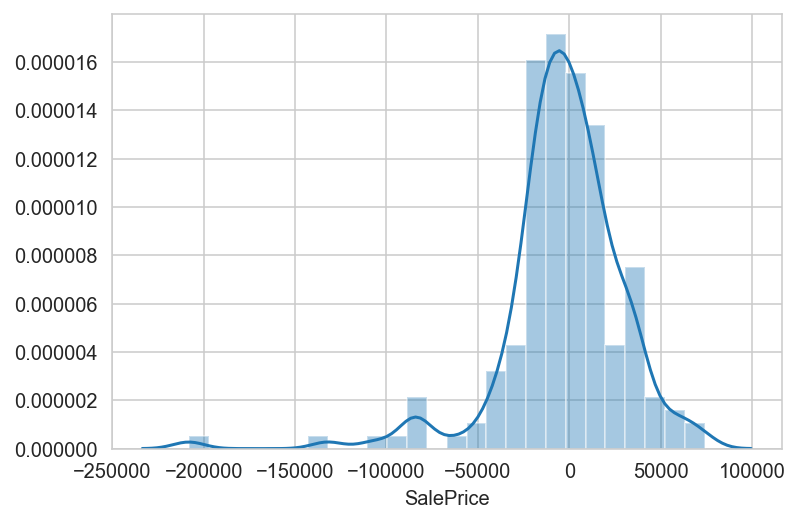

In [38]:
sns.distplot(Residual)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [39]:
house[renovatable].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 26 columns):
Condition1       1450 non-null object
Condition2       1450 non-null object
OverallQual      1450 non-null object
OverallCond      1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-null object
MasVnrType       1450 non-null object
ExterQual        1450 non-null object
ExterCond        1450 non-null object
BsmtQual         1450 non-null object
BsmtCond         1450 non-null object
BsmtFinType1     1450 non-null object
BsmtFinType2     1450 non-null object
Heating          1450 non-null object
HeatingQC        1450 non-null object
CentralAir       1450 non-null object
Electrical       1450 non-null object
KitchenQual      1450 non-null object
FireplaceQu      1450 non-null object
GarageQual       1450 non-null object
GarageCond       1450 non-null object
PavedDrive       1450 non-null object
PoolQC           14

In [42]:
# Set X and y

y_rev  = pd.DataFrame((y_pred_p - y_test))
X_rev  = house[renovatable]
# get the dummies of x 
X_rev = pd.get_dummies(X_rev, drop_first=True)
X1_rev =ss.fit_transform(X_rev)

# create DataFrame of X1_rev that already fit and transform by StandaradScaler
X1_rev = pd.DataFrame(X1_rev,columns=X_rev.columns)
# select only the row that related to YrSold 2010 
X1_rev = X1_rev.iloc[house[house['YrSold'] == '2010'].index]



In [43]:
# Modeled the linear regession by using Sklearn
lr = LinearRegression()
model =lr.fit(X1_rev,y_rev)

model.score(X1_rev,y_rev)




0.7037137261313329

In [44]:
coefficient.shape

NameError: name 'coefficient' is not defined

In [45]:
# Create a Coefficient of the model to see potential parameter that can be a parameter that compnay can make profit
coefficient=model.coef_
coef_df = pd.DataFrame(coefficient,columns=X1_rev.columns).T
coef_df.columns= ['coef']

coef_df.sort_values('coef',ascending= False).head(30)

,coef
Condition2_PosN,2.538097e+18
Condition2_PosA,7.037295e+17
RoofMatl_Roll,6.346692e+17
OverallQual_5,2.307446e+17
OverallQual_6,2.263737e+17
Exterior1st_AsphShn,2.160115e+17
OverallQual_7,2.145311e+17
RoofMatl_WdShngl,2.142848e+17
GarageQual_TA,1.906481e+17
OverallQual_8,1.657533e+17


According to the model these are the list of parameter of the properties that company can use to renovate a house

Condition2 =PosN	Near positive off-site feature--park, greenbelt, etc.
Condition2 =PosA	Adjacent to postive off-site feature

Use RoofMaterial = Roll, Wood Shingles which result in higher dollar return
Use Asbestos Shingles as Exterior covering on house when renovate
The Fair and Typical/ Average Garage is the most valuable factor in the GarageQuality. it means that the Quality of Garage sometimes do not need to renovate as that should not be a the very good condition

OverallQual_ = 4-9

In [46]:
# try this one with the statmodels and run the summary
import statsmodels.api as sm
from statsmodels.api import OLS
model = sm.OLS(y_rev, X1_rev ).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     2.273
Date:                Thu, 24 Sep 2020   Prob (F-statistic):           0.000116
Time:                        16:48:56   Log-Likelihood:                -1927.4
No. Observations:                 172   AIC:                             4041.
Df Residuals:                      79   BIC:                             4333.
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Condition1_Feedr      -3735.9597   4730.976     -0.790      0.432   -1.32e+04    5680.813
Condition1_Norm       -9604.5117   6102.904     -1.574      0.120   -2.18e+04    2543.015
Condition1_PosA        -492.3652   2126.005     -0.232      0.817   -4724.072    3739.342
Condition1_PosN        -357.0410   3344.662     -0.107      0.915   -7014.425    6300.343
Condition1_RRAe        1694.3842   2592.298      0.654      0.515   -3465.455    6854.224
Condition1_RRAn         987.3418   2464.090      0.401      0.690   -3917.307    5891.991
Condition1_RRNe       -1314.3328   1387.001     -0.948      0.346   -4075.089    1446.423
Condition1_RRNn       -4162.2767   5155.970     -0.807      0.422   -1.44e+04    6100.424
Condition2_Feedr        -40.9848   2703.120     -0.015      0.988   -5421.411    5339.441
Condition2_Norm        -560.1971   1897.783     -0.295      0.769   -4337.639    3217.245
Condition2_PosA         242.0178    587.986      0.412      0.682    -928.340    1412.375
Condition2_PosN         342.3830    831.825      0.412      0.682   -1313.324    1998.090
Condition2_RRAe         242.0178    587.986      0.412      0.682    -928.340    1412.375
Condition2_RRAn         242.0178    587.986      0.412      0.682    -928.340    1412.375
Condition2_RRNn         342.3830    831.825      0.412      0.682   -1313.324    1998.090
OverallQual_10         1032.8713   2509.378      0.412      0.682   -3961.921    6027.664
OverallQual_2           342.3830    831.825      0.412      0.682   -1313.324    1998.090
OverallQual_3           175.3268   5151.586      0.034      0.973   -1.01e+04    1.04e+04
OverallQual_4          2181.2527   2829.473      0.771      0.443   -3450.673    7813.178
OverallQual_5          5131.7693   3680.400      1.394      0.167   -2193.883    1.25e+04
OverallQual_6         -1090.6365   2428.916     -0.449      0.655   -5925.272    3743.999
OverallQual_7         -2289.4224   2701.192     -0.848      0.399   -7666.011    3087.166
OverallQual_8         -3042.3801   3159.781     -0.963      0.339   -9331.766    3247.006
OverallQual_9         -3694.7608   3797.008     -0.973      0.333   -1.13e+04    3862.995
OverallCond_2          -190.2218   2587.205     -0.074      0.942   -5339.925    4959.481
OverallCond_3          3000.7115   4843.665      0.620      0.537   -6640.363    1.26e+04
OverallCond_4          3101.1529   5483.129      0.566      0.573   -7812.742     1.4e+04
OverallCond_5          1251.3656   2293.991      0.545      0.587   -3314.709    5817.440
OverallCond_6          1129.9517   2535.232      0.446      0.657   -3916.301    6176.204
OverallCond_7         -1964.8501   2392.150     -0.821      0.414   -6726.306    2796.606
OverallCond_8         -5335.4158   3318.306     -1.608      0.112   -1.19e+04    1269.507
OverallCond_9         -

In [ ]:
# After I run the Statmodels again, the results is difference which result that my model might be wrong in some reasons.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: